# 화장품 리뷰 데이터 분석

## 1. 데이터 분석 목적성 및 수집
30,000개의 화장품 리뷰 데이터를 자연어처리를 하고선 6개의 카테고리로 분류하기

##### 데이터 수집

In [41]:
import pandas as pd

beauty = pd.read_excel('beauty_data_sample.xlsx')

##### 데이터 섞기

In [42]:
beauty = beauty.sample(frac=1).reset_index(drop=True)

In [63]:
beauty.head()

,category,contents
0,용량,재구매한건데 그럭저럭사용할만해요 ㅋㅋ근데 용량이 적다는 엄마왈 재구매한건데 그럭...
1,색상,너무 저렴하게 잘 샀어요^^감사합니다^^ 색도 이뻐요 ~
2,디자인,색상도 이쁘고 너무 좋아요
3,용량,이건일회용인가요?ㅋ 양이정만작네요 ...그가격만큼요
4,디자인,"연령대 : 30대 피부타입(건성,지성,복합성): 지성. 피부 제품사용횟수 또는..."


## 2. 데이터 분리

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(beauty.contents, beauty.category, test_size=0.2, stratify=beauty.category, random_state=42)

## 3. 데이터 전처리
회사에서 제공하는 keyterm client 모듈을 사용해 문장의 토크나이징

In [55]:
from keyterm_client import KeytermClient

kc = KeytermClient()

# 'AJMA'        형용사
# 'NNIN1'       고유명사
# 'NNIN2'       일반명사
# 'VBMA'        동사

X_train_sentence = []
X_train_sentence2 = []
for idx, contents in enumerate(X_train.values):
    data = kc.get_morphemes(body=contents, filter_option=['AJMA','NNIN1','NNIN2','VBMA'])
    X_train_sentence.append(data)
    X_train_sentence2.extend(data)

X_test_sentence = []
X_test_sentence2 = []
for idx, contents in enumerate(X_test.values):
    data = kc.get_morphemes(body=contents, filter_option=['AJMA','NNIN1','NNIN2','VBMA'])
    X_test_sentence.append(data)
    X_test_sentence2.extend(data)

##### 정수 인코딩
각 단어를 고유한 정수에 맵핑(mapping)시키는 작업

In [121]:
from collections import Counter

train_counts = Counter(X_train_sentence2)
test_counts = Counter(X_test_sentence2)

In [122]:
train_counts_sorted = sorted(train_counts.items(), key=lambda x : x[1], reverse=True)
test_counts_sorted = sorted(test_counts.items(), key=lambda x : x[1], reverse=True)

In [123]:
train_vocab = sorted(train_counts, key=train_counts.get, reverse=True)
test_vocab = sorted(test_counts, key=test_counts.get, reverse=True)

In [124]:
print(len(train_vocab))
print(len(test_vocab))

16834
7337


In [125]:
# 높은 빈도수를 가진 단어일수록 낮은 정수 인덱스 부여(훈련 데이터)
word_mapping_table = {}

idx = 0
for (word, frequency) in train_counts_sorted :
    word_mapping_table[word] = idx
    idx += 1

word_mapping_table_sorted = sorted(word_mapping_table.items(), key=lambda x : x[1], reverse=False)

In [126]:
len(word_mapping_table_sorted)

16834

In [136]:
X_train_Integer_Encoding = []
for sentence in X_train_sentence:
    w = []
    for word in sentence:
        w.append(word_mapping_table[word])
    X_train_Integer_Encoding.append(w)

In [144]:
X_test_Integer_Encoding = []
for sentence in X_test_sentence:
    w = []
    for word in sentence:
        if word in word_mapping_table:
            w.append(word_mapping_table[word])
        else:
            pass
            
    X_test_Integer_Encoding.append(w)

##### 원-핫 인코딩
단어 집합의 크기를 벡터의 차원으로 하고, 표현하고 싶은 단어의 인덱스에 1의 값을 부여하고, 다른 인덱스에는 0을 부여하는 단어의 벡터 표현 방식

In [147]:
X_train_Onehot_Encoding = list()
for value in X_train_Integer_Encoding:
    letter = [0 for _ in range(len(word_mapping_table))]
    for v in value:
        letter[v] = 1
    X_train_Onehot_Encoding.append(letter)
    
X_test_Onehot_Encoding = list()
for value in X_test_Integer_Encoding:
    letter = [0 for _ in range(len(word_mapping_table))]
    for v in value:
        letter[v] = 1
    X_test_Onehot_Encoding.append(letter)

In [148]:
sorted_mapping_keys = [word_mapping_table_sorted[idx][0] for idx in range(len(word_mapping_table_sorted))]

In [149]:
X_train_df = pd.DataFrame(X_train_Onehot_Encoding, columns=sorted_mapping_keys)
X_test_df = pd.DataFrame(X_test_Onehot_Encoding, columns=sorted_mapping_keys)

In [16]:
# 타겟 데이터 매핑 테이블
target_names = list(set(beauty.category))
print(target_names)

target_mapping_table = {}
for idx, names in enumerate(target_names):
    target_mapping_table[names] = idx

['색상', '디자인', '향기', '용량', '감촉', '가격']


In [80]:
# 타겟 데이터프레임 생성
y_train_df = pd.DataFrame(columns=['target'])
for idx, target in enumerate(y_train.values):
    for key, value in target_mapping_table.items():
        if target == key:
            y_train_df.loc[idx, 'target'] = value
            
y_test_df = pd.DataFrame(columns=['target'])
for idx, target in enumerate(y_test.values):
    for key, value in target_mapping_table.items():
        if target == key:
            y_test_df.loc[idx, 'target'] = value

y_train_df = y_train_df.astype(int)
y_test_df = y_test_df.astype(int)

In [150]:
train_df = pd.concat([X_train_df, y_train_df], axis=1)
test_df = pd.concat([X_test_df, y_test_df], axis=1)

In [151]:
train_df.head()

,좋다,쓰다,같다,하다,제품,가격,저렴하다,향,사다,배송,...,퍼피,맨살,양자,좋겟엥영,구마하다,머리감다,평범,사리,칼바람부,target
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2
4,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3


In [152]:
test_df.head()

,좋다,쓰다,같다,하다,제품,가격,저렴하다,향,사다,배송,...,퍼피,맨살,양자,좋겟엥영,구마하다,머리감다,평범,사리,칼바람부,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [153]:
onehot_X_train = train_df.iloc[:, 0:len(sorted_mapping_keys)].values
onehot_y_train = train_df.loc[:, 'target'].values

print(onehot_X_train.shape)
print(onehot_y_train.shape)

onehot_X_test = test_df.iloc[:, 0:len(sorted_mapping_keys)].values
onehot_y_test = test_df.loc[:, 'target'].values

print(onehot_X_test.shape)
print(onehot_y_test.shape)

(24000, 16834)
(24000,)
(6000, 16834)
(6000,)


Sparse Data로 변환

In [154]:
from scipy.sparse import csr_matrix

onehot_X_train = csr_matrix(onehot_X_train)
onehot_X_test = csr_matrix(onehot_X_test)

##### 분석 모델에 사용될 최종 훈련 데이터 및 테스트 데이터
##### train: onehot_X_train, onehot_y_train  
##### test: onehot_X_test, onehot_y_test

## 4. 분석 모델로 데이터 훈련
#### 다중 멀티 클래스와 멀티 라벨을 위한 classifier의 종류

_[Inherently multiclass]_

+ sklearn.tree.DecisionTreeClassifier
+ sklearn.ensemble.ExtraTreesClassifier
+ sklearn.naive_bayes.GaussianNB
+ sklearn.neighbors.KNeighborsClassifier
+ sklearn.svm.LinearSVC (setting multi_class=”crammer_singer”)
+ sklearn.linear_model.LogisticRegression (setting multi_class=”multinomial”)
+ sklearn.ensemble.RandomForestClassifier
+ sklearn.linear_model.RidgeClassifier (규제가 필요한 경우)  
<br/>
<br/>

_[Multiclass as One-Vs-One]_

+ sklearn.svm.SVC.
+ sklearn.gaussian_process.GaussianProcessClassifier (setting multi_class = “one_vs_one”)
<br/>
<br/>

_[Multiclass as One-Vs-The-Rest]_

+ sklearn.ensemble.GradientBoostingClassifier
+ sklearn.svm.LinearSVC (setting multi_class=”ovr”)
+ sklearn.linear_model.LogisticRegression (setting multi_class=”ovr”)
+ sklearn.linear_model.SGDClassifier
+ sklearn.linear_model.Perceptron
<br/>
<br/>

_[Support multilabel]_

+ sklearn.tree.DecisionTreeClassifier
+ sklearn.ensemble.ExtraTreesClassifier
+ sklearn.neighbors.KNeighborsClassifier
+ sklearn.ensemble.RandomForestClassifier
<br/>
<br/>

_[Support multiclass-multioutput]_

+ sklearn.tree.DecisionTreeClassifier
+ sklearn.ensemble.ExtraTreesClassifier
+ sklearn.neighbors.KNeighborsClassifier
+ sklearn.ensemble.RandomForestClassifier

여러가지 분류 모델을 사용한 결과 제일 좋은 성능인 SGDClassifier와 GradientBoostingClassifier로만 사용

#### SGDClasifier

In [161]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000)

In [162]:
from sklearn.model_selection import cross_val_score
import numpy as np

sgd_clf_scores = cross_val_score(sgd_clf, onehot_X_train, onehot_y_train, n_jobs=-1, cv=5, scoring='accuracy')
print('SGDClassifier accuracy: {:.3f}'.format(np.mean(sgd_clf_scores)))

SGDClassifier accuracy: 0.875


최적의 하이퍼파라미터 구하기

In [163]:
opt_onehot_sgd_clf = SGDClassifier(loss='modified_huber', max_iter=1000, alpha=1e-3, random_state=42)
opt_onehot_sgd_clf.fit(onehot_X_train, onehot_y_train)

SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='modified_huber', max_iter=1000,
       n_iter=None, n_jobs=1, penalty='l2', power_t=0.5, random_state=42,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [164]:
opt_onehot_sgd_clf_y_pred = opt_onehot_sgd_clf.predict(onehot_X_test)

In [165]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('[SGDClassifier Precision ~ F1]')
print('Accuracy:  {:.3f}'.format(accuracy_score(onehot_y_test, opt_onehot_sgd_clf_y_pred)))
print('Precision: {:.3f}'.format(precision_score(onehot_y_test, opt_onehot_sgd_clf_y_pred, average='macro')))
print('Recall:    {:.3f}'.format(recall_score(onehot_y_test, opt_onehot_sgd_clf_y_pred, average='macro')))
print('F1_score:  {:.3f}'.format(f1_score(onehot_y_test, opt_onehot_sgd_clf_y_pred, average='macro')))

[SGDClassifier Precision ~ F1]
Accuracy:  0.879
Precision: 0.879
Recall:    0.879
F1_score:  0.878


#### GradientBoostinfClassifier

In [166]:
from sklearn.ensemble import GradientBoostingClassifier
from numpy.core.umath_tests import inner1d

gb_clf = GradientBoostingClassifier()

In [167]:
gb_clf_scores = cross_val_score(gb_clf, onehot_X_train, onehot_y_train, n_jobs=-1, cv=5, scoring='accuracy')
print('GradientBoostingClassifier accuracy: {:.3f}'.format(np.mean(gb_clf_scores)))

GradientBoostingClassifier accuracy: 0.872


최적의 하이퍼파라미터 구하기

In [200]:
from sklearn.model_selection import validation_curve

gb_clf2 = GradientBoostingClassifier(random_state=42)
param_name2 = 'n_estimators'
param_range2 = [100, 300, 500, 700]
scoring2 = 'accuracy'

train_scores2, test_scores2 = validation_curve(gb_clf2, onehot_X_train, onehot_y_train, 
                                               param_name=param_name2, param_range=param_range2, cv=3, 
                                               scoring=scoring2, n_jobs=-1)

In [201]:
train_scores_mean2 = np.mean(train_scores2, axis=1)
train_scores_std2 = np.std(train_scores2, axis=1)
test_scores_mean2 = np.mean(test_scores2, axis=1)
test_scores_std2 = np.std(test_scores2, axis=1)

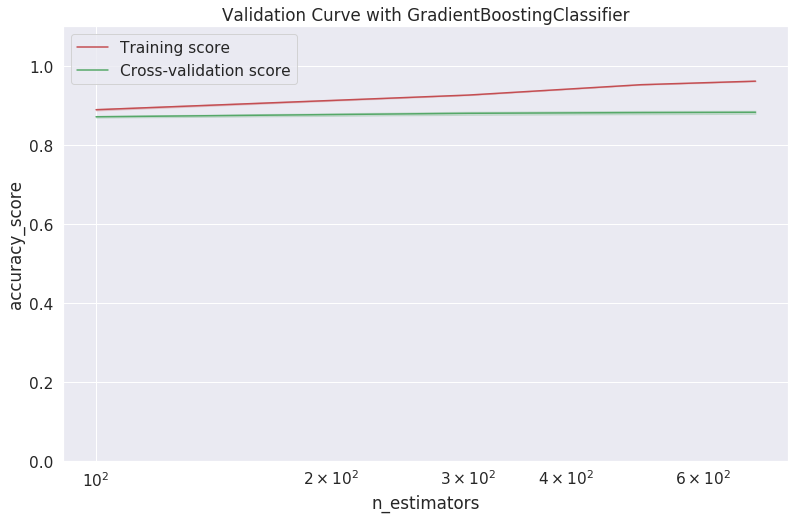

In [202]:
plt.figure(figsize=(13, 8))
plt.semilogx(param_range2, train_scores_mean2, label="Training score", color="r")
plt.fill_between(param_range2, train_scores_mean2 - train_scores_std2, train_scores_mean2 + train_scores_std2, alpha=0.2, color="r")
plt.semilogx(param_range2, test_scores_mean2, label="Cross-validation score", color="g")
plt.fill_between(param_range2, test_scores_mean2 - test_scores_std2, test_scores_mean2 + test_scores_std2, alpha=0.2, color="g")
plt.legend(loc="best")
plt.title("Validation Curve with GradientBoostingClassifier")
plt.xlabel("n_estimators")
plt.ylabel("accuracy_score")
plt.ylim(0.0, 1.1)
plt.show()

In [205]:
from sklearn.model_selection import validation_curve

gb_clf3 = GradientBoostingClassifier(n_estimators=400, random_state=42)
param_name3 = 'max_depth'
param_range3 = [i for i in range(1, 30)]
scoring3 = 'accuracy'

train_scores2, test_scores2 = validation_curve(gb_clf3, onehot_X_train, onehot_y_train, 
                                               param_name=param_name3, param_range=param_range3, cv=3, 
                                               scoring=scoring3, n_jobs=-1)

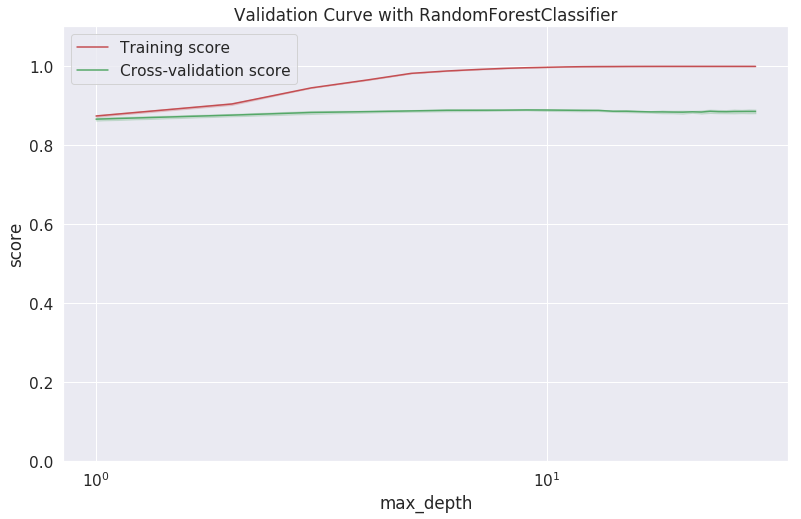

In [207]:
train_scores_mean3 = np.mean(train_scores2, axis=1)
train_scores_std3 = np.std(train_scores2, axis=1)
test_scores_mean3 = np.mean(test_scores2, axis=1)
test_scores_std3 = np.std(test_scores2, axis=1)

plt.figure(figsize=(13, 8))
plt.semilogx(param_range3, train_scores_mean3, label="Training score", color="r")
plt.fill_between(param_range3, train_scores_mean3 - train_scores_std3, train_scores_mean3 + train_scores_std3, alpha=0.2, color="r")
plt.semilogx(param_range3, test_scores_mean3, label="Cross-validation score", color="g")
plt.fill_between(param_range3, test_scores_mean3 - test_scores_std3, test_scores_mean3 + test_scores_std3, alpha=0.2, color="g")
plt.legend(loc="best")
plt.title("Validation Curve with RandomForestClassifier")
plt.xlabel("max_depth")
plt.ylabel("score")
plt.ylim(0.0, 1.1)
plt.show()

In [208]:
from sklearn.model_selection import validation_curve

gb_clf4 = GradientBoostingClassifier(n_estimators=400, max_depth=8, random_state=42)
param_name4 = 'learning_rate'
param_range4 = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 1.0]
scoring4 = 'accuracy'

train_scores4, test_scores4 = validation_curve(gb_clf4, onehot_X_train, onehot_y_train, 
                                               param_name=param_name4, param_range=param_range4, cv=3, 
                                               scoring=scoring4, n_jobs=-1)

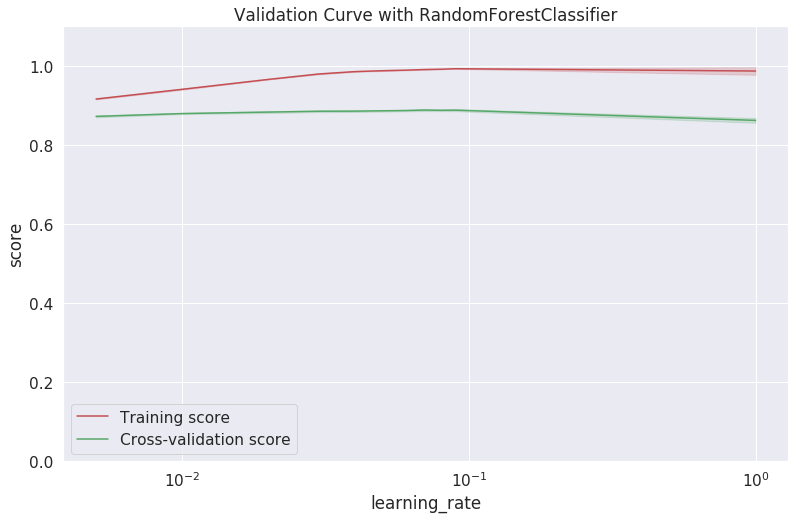

In [217]:
train_scores_mean4 = np.mean(train_scores4, axis=1)
train_scores_std4 = np.std(train_scores4, axis=1)
test_scores_mean4 = np.mean(test_scores4, axis=1)
test_scores_std4 = np.std(test_scores4, axis=1)

plt.figure(figsize=(13, 8))
plt.semilogx(param_range4, train_scores_mean4, label="Training score", color="r")
plt.fill_between(param_range4, train_scores_mean4 - train_scores_std4, train_scores_mean4 + train_scores_std4, alpha=0.2, color="r")
plt.semilogx(param_range4, test_scores_mean4, label="Cross-validation score", color="g")
plt.fill_between(param_range4, test_scores_mean4 - test_scores_std4, test_scores_mean4 + test_scores_std4, alpha=0.2, color="g")
plt.legend(loc="best")
plt.title("Validation Curve with RandomForestClassifier")
plt.xlabel("learning_rate")
plt.ylabel("score")
plt.ylim(0.0, 1.1)
plt.show()

** 여섯 번째 모델 **

In [214]:
opt_onehot_gb_clf6 = GradientBoostingClassifier(n_estimators=400, max_depth=8, learning_rate=0.1, random_state=42)
opt_onehot_gb_clf6.fit(onehot_X_train, onehot_y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=400,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [215]:
opt_onehot_gb_clf_y_pred6 = opt_onehot_gb_clf6.predict(onehot_X_test)

In [216]:
print('[GradientBoostingClassifier Precision ~ F1]')
print('Accuracy:  {:.3f}'.format(accuracy_score(onehot_y_test, opt_onehot_gb_clf_y_pred6)))
print('Precision: {:.3f}'.format(precision_score(onehot_y_test, opt_onehot_gb_clf_y_pred6, average='macro')))
print('Recall:    {:.3f}'.format(recall_score(onehot_y_test, opt_onehot_gb_clf_y_pred6, average='macro')))
print('F1_score:  {:.3f}'.format(f1_score(onehot_y_test, opt_onehot_gb_clf_y_pred6, average='macro')))

[GradientBoostingClassifier Precision ~ F1]
Accuracy:  0.894
Precision: 0.893
Recall:    0.894
F1_score:  0.893


** 일곱 번째 모델 **

In [221]:
opt_onehot_gb_clf7 = GradientBoostingClassifier(n_estimators=600, max_depth=10, learning_rate=0.1, random_state=42)
opt_onehot_gb_clf7.fit(onehot_X_train, onehot_y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=600,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [222]:
opt_onehot_gb_clf_y_pred7 = opt_onehot_gb_clf7.predict(onehot_X_test)

In [223]:
print('[GradientBoostingClassifier Precision ~ F1]')
print('Accuracy:  {:.3f}'.format(accuracy_score(onehot_y_test, opt_onehot_gb_clf_y_pred7)))
print('Precision: {:.3f}'.format(precision_score(onehot_y_test, opt_onehot_gb_clf_y_pred7, average='macro')))
print('Recall:    {:.3f}'.format(recall_score(onehot_y_test, opt_onehot_gb_clf_y_pred7, average='macro')))
print('F1_score:  {:.3f}'.format(f1_score(onehot_y_test, opt_onehot_gb_clf_y_pred7, average='macro')))

[GradientBoostingClassifier Precision ~ F1]
Accuracy:  0.894
Precision: 0.894
Recall:    0.894
F1_score:  0.894


가장 좋은 모델의 정밀도와 재현율 곡선 그래프

In [297]:
en_target_names = ['color', 'design', 'scent', 'volume', 'texture', 'price']

In [274]:
from sklearn.preprocessing import label_binarize

n_classes = len(en_target_names)

binary_onehot_test = label_binarize(onehot_y_test, classes=[*range(n_classes)])
binary_onehot_scores = label_binarize(onehot_y_scores, classes=[*range(n_classes)])

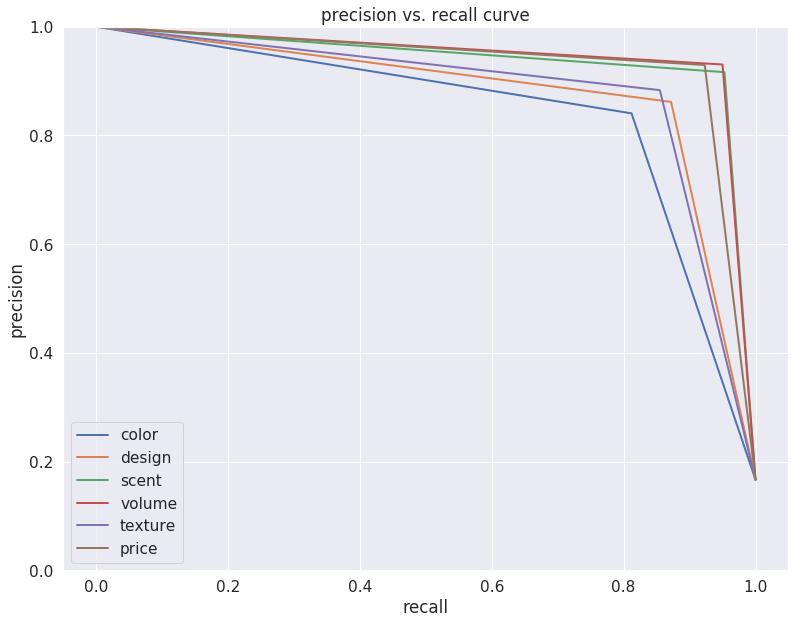

In [300]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib

path_gothic = "NanumGothic.ttf"
prop = fm.FontProperties(fname=path_gothic)
matplotlib.rcParams["axes.unicode_minus"] = False

plt.figure(figsize=(13, 10))

precision = dict()
recall = dict()
for idx in range(len(target_names)):
    precision[idx], recall[idx], _ = precision_recall_curve(binary_onehot_test[:, idx], binary_onehot_scores[:, idx])
    plt.plot(recall[idx], precision[idx], lw=2, label='{}'.format(en_target_names[idx]))
    plt.legend(loc="center left")
    plt.ylim([0, 1])
   
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

** 첫 번째 모델 **

In [110]:
opt_onehot_gb_clf = GradientBoostingClassifier(n_estimators=200, max_depth=20, learning_rate=0.05, random_state=42)
opt_onehot_gb_clf.fit(onehot_X_train, onehot_y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=20,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [113]:
opt_onehot_gb_clf_y_pred = opt_onehot_gb_clf.predict(onehot_X_test)

In [114]:
print('[GradientBoostingClassifier Precision ~ F1]')
print('Accuracy:  {:.3f}'.format(accuracy_score(onehot_y_test, opt_onehot_gb_clf_y_pred)))
print('Precision: {:.3f}'.format(precision_score(onehot_y_test, opt_onehot_gb_clf_y_pred, average='macro')))
print('Recall:    {:.3f}'.format(recall_score(onehot_y_test, opt_onehot_gb_clf_y_pred, average='macro')))
print('F1_score:  {:.3f}'.format(f1_score(onehot_y_test, opt_onehot_gb_clf_y_pred, average='macro')))

[GradientBoostingClassifier Precision ~ F1]
Accuracy:  0.887
Precision: 0.886
Recall:    0.887
F1_score:  0.886


** 두 번째 모델 **

In [115]:
opt_onehot_gb_clf2 = GradientBoostingClassifier(n_estimators=200, max_depth=20, learning_rate=0.02, random_state=42)
opt_onehot_gb_clf2.fit(onehot_X_train, onehot_y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.02, loss='deviance', max_depth=20,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [116]:
opt_onehot_gb_clf_y_pred2 = opt_onehot_gb_clf2.predict(onehot_X_test)

In [117]:
print('[GradientBoostingClassifier Precision ~ F1]')
print('Accuracy:  {:.3f}'.format(accuracy_score(onehot_y_test, opt_onehot_gb_clf_y_pred2)))
print('Precision: {:.3f}'.format(precision_score(onehot_y_test, opt_onehot_gb_clf_y_pred2, average='macro')))
print('Recall:    {:.3f}'.format(recall_score(onehot_y_test, opt_onehot_gb_clf_y_pred2, average='macro')))
print('F1_score:  {:.3f}'.format(f1_score(onehot_y_test, opt_onehot_gb_clf_y_pred2, average='macro')))

[GradientBoostingClassifier Precision ~ F1]
Accuracy:  0.886
Precision: 0.885
Recall:    0.886
F1_score:  0.885


** 세 번째 모델 **

In [176]:
opt_onehot_gb_clf3 = GradientBoostingClassifier(n_estimators=300, max_depth=25, learning_rate=0.01, random_state=42)
opt_onehot_gb_clf3.fit(onehot_X_train, onehot_y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=25,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [177]:
opt_onehot_gb_clf_y_pred3 = opt_onehot_gb_clf3.predict(onehot_X_test)

In [178]:
print('[GradientBoostingClassifier Precision ~ F1]')
print('Accuracy:  {:.3f}'.format(accuracy_score(onehot_y_test, opt_onehot_gb_clf_y_pred3)))
print('Precision: {:.3f}'.format(precision_score(onehot_y_test, opt_onehot_gb_clf_y_pred3, average='macro')))
print('Recall:    {:.3f}'.format(recall_score(onehot_y_test, opt_onehot_gb_clf_y_pred3, average='macro')))
print('F1_score:  {:.3f}'.format(f1_score(onehot_y_test, opt_onehot_gb_clf_y_pred3, average='macro')))

[GradientBoostingClassifier Precision ~ F1]
Accuracy:  0.878
Precision: 0.878
Recall:    0.878
F1_score:  0.878


** 네 번째 모델 **

In [179]:
opt_onehot_gb_clf4 = GradientBoostingClassifier(n_estimators=500, max_depth=25, learning_rate=0.01, random_state=42)
opt_onehot_gb_clf4.fit(onehot_X_train, onehot_y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=25,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [180]:
opt_onehot_gb_clf_y_pred4 = opt_onehot_gb_clf4.predict(onehot_X_test)

In [181]:
print('[GradientBoostingClassifier Precision ~ F1]')
print('Accuracy:  {:.3f}'.format(accuracy_score(onehot_y_test, opt_onehot_gb_clf_y_pred4)))
print('Precision: {:.3f}'.format(precision_score(onehot_y_test, opt_onehot_gb_clf_y_pred4, average='macro')))
print('Recall:    {:.3f}'.format(recall_score(onehot_y_test, opt_onehot_gb_clf_y_pred4, average='macro')))
print('F1_score:  {:.3f}'.format(f1_score(onehot_y_test, opt_onehot_gb_clf_y_pred4, average='macro')))

[GradientBoostingClassifier Precision ~ F1]
Accuracy:  0.881
Precision: 0.880
Recall:    0.881
F1_score:  0.880


** 다섯 번째 모델 **

In [182]:
opt_onehot_gb_clf5 = GradientBoostingClassifier(n_estimators=200, max_depth=20, learning_rate=1, random_state=42)
opt_onehot_gb_clf5.fit(onehot_X_train, onehot_y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1, loss='deviance', max_depth=20,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [183]:
opt_onehot_gb_clf_y_pred5 = opt_onehot_gb_clf5.predict(onehot_X_test)

In [184]:
print('[GradientBoostingClassifier Precision ~ F1]')
print('Accuracy:  {:.3f}'.format(accuracy_score(onehot_y_test, opt_onehot_gb_clf_y_pred5)))
print('Precision: {:.3f}'.format(precision_score(onehot_y_test, opt_onehot_gb_clf_y_pred5, average='macro')))
print('Recall:    {:.3f}'.format(recall_score(onehot_y_test, opt_onehot_gb_clf_y_pred5, average='macro')))
print('F1_score:  {:.3f}'.format(f1_score(onehot_y_test, opt_onehot_gb_clf_y_pred5, average='macro')))

[GradientBoostingClassifier Precision ~ F1]
Accuracy:  0.877
Precision: 0.877
Recall:    0.877
F1_score:  0.877


** 일곱 번째 모델의 오차행렬 **

In [228]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

index = ['Color', 'Design', 'Scent', 'Volume', 'Texture', 'Price']
gb_clf_df = pd.DataFrame(confusion_matrix(onehot_y_test, opt_onehot_gb_clf_y_pred7), index=index, columns=index)

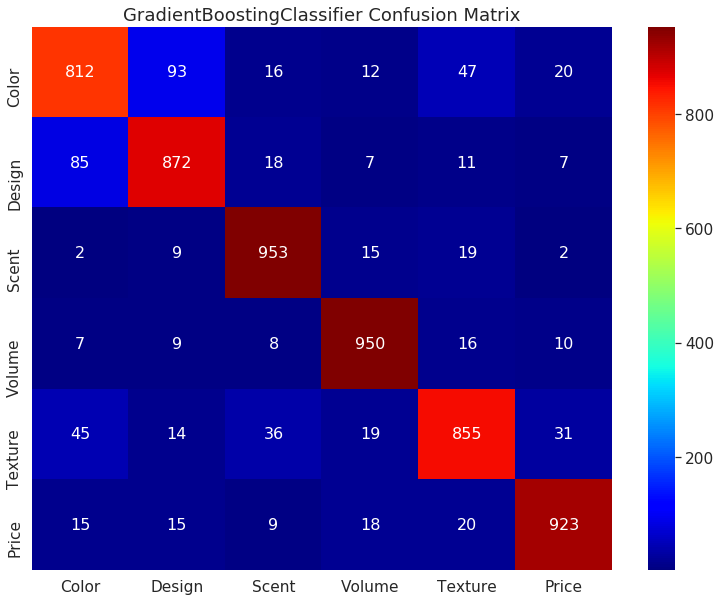

In [229]:
plt.figure(figsize=(13, 10))
plt.title("GradientBoostingClassifier Confusion Matrix", fontsize=18)

sns.set(font_scale = 1.4)
sns.heatmap(gb_clf_df, fmt="d", cmap="jet", annot=True, annot_kws={"size": 16}) # font size

plt.show()